# Hyper-minimization of DFAs

### Automata-lib

Here is the import of the automata-lib library. It is a Python library that provides a simple interface to work with deterministic finite state automata. It is used to create, manipulate, and visualize automata.

In [1]:
from automata.fa.dfa import DFA

### Performance profiling

In [2]:
import timeit
import speedscope
import random
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import math

In [3]:
%load_ext pyinstrument

### Utils

It's very common that the automata needs to mute over the time, so since the automata-lib doesn't provide a mutable version of the DFA class, a mutable version of the DFA class is implemented which is used to perform the hyper-minimization algorithm and which is used to build the hyper-minimized automata.

In [4]:
class IncrementalDFA:
  def __init__(self, dfa: DFA = None, deep_copy=False):
    """
    Initialize an incremental DFA.
    """
    if dfa is None:
      self.__empty_init()
    else:
      self.states = set(dfa.states)
      self.transitions = dict(dfa.transitions)
      if deep_copy:
        for key in self.transitions.keys():
          self.transitions[key] = dict(self.transitions[key])   
      self.initial_state = dfa.initial_state
      self.final_states = set(dfa.final_states)
      self.input_symbols = set(dfa.input_symbols)

  def __empty_init(self):
    """
    Initialize an empty incremental DFA.
    """
    self.states = set()
    self.transitions = dict()
    self.initial_state = None
    self.final_states = set()
    self.input_symbols = set()

  def build(self) -> DFA:
    """
    Build and returns the DFA.
    """
    return DFA(
      states=self.states,
      input_symbols=self.input_symbols,
      transitions=self.transitions,
      initial_state=self.initial_state,
      final_states=self.final_states
    )

Moreover a color palette for the graphs is defined.

In [5]:
color_palette = ['#d4fce9', '#96e4c1', '#48b89f', '#2d7d90', '#113b55', '#001f30', '#000000']

### Badr-Geffert-Shipman Algorithm 

#### Introduction

The first implemented algorithm is the one descrived in the [original paper](http://www.numdam.org/article/ITA_2009__43_1_69_0.pdf) regarding the hyper minimization of DFAs by Andrew Badr, Viliam Geffert and Ian Shipman.

This algorithm can be broken down in the following high-level steps:
- minimization (in the standard way i.e. using Hopcroft (preferred) or Brzozowski) of the input DFA
- identification of the states in the kernel and in the preamble
- collapse of the preamble states into other state in the same almost-equivalence class

More in detail, the algorithm works by performing a pre-processing to facilitate the operation of identifying the kernel states through the construction of a matrix $E$, the generic element $e_{i,j}$ is assigned as follows:

$$
\begin{equation*}
e_{i,j} =
  \begin{cases}
  1 \text{ if the state $q_j$ can be reached from the state $q_j$ with a path of length $> 0$} \\
  0 \text{ otherwise}
  \end{cases}
\end{equation*}
$$

Next, builds a $K$ vector where the $i$-th element, corresponding to the $q_i$ state, is $1$ if the $i$-th state is in the kernel, $0$ otherwise, this task is accomplished by checking the elements of the matrix $E$, more precisely, the generic element $k_{i}$ is assigned as follows:

$$
\begin{equation*}
k_{i} =
  \begin{cases}
  1 \text{ if $e_{1,j} = e_{j,j} = e_{j, i} = 1$ } \\
  0 \text{ otherwise}
  \end{cases}
\end{equation*}
$$

Finally, the algorithm calculates the almost-equivalence classes and collapses the preamble states into a kernel state if the almost-equivalence class contains both kernel and preamble states or collapses the preamble states into a non-kernel state if the almost-equivalence class contains only preamble states.

This last step is performed constructing a $P$ vector that associates to each state $q_i$ the set of the partition to which it belongs.

Initially, the partition is defined as follows: $P = \{ \{q_1\}, \{q_2\}, \dots, \{q_n\} \}$, then the algorithm iterates over the states and for each couple of states $q_i$ and $q_j$ checks if they are in the same almost-equivalence class, if they are, the algorithm merges the partitions to which they belong, mathematically, the almost-equivalence of two states not known to be almost-equivalent is checked as follows:

$$q_{i} \sim q_{j} \iff \forall \alpha \in \Sigma \quad \delta(q_{i}, \alpha), \delta(q_{j}, \alpha) \in Q_\alpha$$

#### Implementation

First of all, the `breadth_first_search` function is defined below, which returns the set of states reachable from a given state $q_i$ in the given automaton.

It is well known that this runs in $O(n \times m)$ time, where $n$ is the number of states of the automaton and $m$ is the number of symbols in the alphabet accepted by the automaton.

In [6]:
def breadth_first_search(dfa: IncrementalDFA, initial) -> set:
  """
  Breadth-first search on the DFA from the initial state.
  O(n * m) time complexity, where n is the number of states and m is the number of input symbols.
  """
  # Note: added this small change so that the initial state is not added if 
  # not reachable from other states reachable from it
  cold_start = True

  # classic BFS
  visited = set()
  queue = [initial]
  while queue:
    current = queue.pop(0)

    if not cold_start:
      visited.add(current)
    else:
      cold_start = False

    for symbol in dfa.input_symbols:
      if dfa.transitions[current][symbol] not in visited:
        queue.append(dfa.transitions[current][symbol])

  return visited

Next, the `badr_geffert_shipman_hyper_minimize` function is defined, which implements the Badr-Geffert-Shipman algorithm, following the steps described above.

In [7]:
def badr_geffert_shipman_hyper_minimize(dfa: DFA) -> DFA:
  """ 
  Hyper-minimize a DFA using the Badr-Geffert-Shipman algorithm.
  O(n^3 * m) time complexity, where n is the number of states and m is the number of input symbols.
  """
  # Step 1: minimization of the DFA
  # Note: the DFA is deep copied (casted) into an IncrementalDFA to allow the modifications needed by the algorithm
  minimal_dfa = IncrementalDFA(dfa.minify(retain_names=True), deep_copy=True)

  # Step 2 (pre-processing): analysis of the reachability in the transition graph (construction of the E matrix)
  # Note: the E matrix is represented by a dictionary of sets, each state represents a row of the matrix, each set contains
  # the values of the row which should be set to 1 in the matrix. This modification is needed in order to perform the 
  # successive step of the algorithm which checks E[1][j] which is not directly possible using integer indexes because
  # the DFA states are represented by a set and the first state is not necessarily the first element of the set.
  E = {q:breadth_first_search(minimal_dfa, q) for q in minimal_dfa.states}

  # Step 3: kernel states identification, made easy by the E matrix (computed in the previous step)
  K = set()
  for q in minimal_dfa.states:
    for r in minimal_dfa.states:
      if r in E[minimal_dfa.initial_state] and r in E[r] and q in E[r]:
        K.add(q)
        break

  # Step 4: almost-equivalence relation computation

  # initial partitioning of the states Q = {q_1} ∪ {q_2} ∪ ... ∪ {q_n}
  P = {i:i for i in minimal_dfa.states}

  # n-1 iterations needed to find all the almost-equivalence relations
  for _ in range(len(minimal_dfa.states)-1):

    # search for almost-equivalent states i.e. couples of states q_i1 and q_i2, with i1 ≠ i2, that
    # are not already in the same set of the partition P but are almost-equivalent and merges the corresponding sets
    for i_1 in minimal_dfa.states:
      for i_2 in minimal_dfa.states:
        if P[i_1] != P[i_2]:
          almost_equivalent = all(P[minimal_dfa.transitions[i_1][sigma]] == P[minimal_dfa.transitions[i_2][sigma]] for sigma in minimal_dfa.input_symbols)
          if almost_equivalent:
            P[i_2] = P[i_1]

  # Step 5: hyper-minimization of the DFA (useless states removal)

  # iterates over the sets of the partition
  # Note: since to each key of the partition dict, which is the name of the state, corresponds tha name of
  # the set to which the state belongs, casting the valoues of the dict to a set allows to execute
  # one and only one iteration for each set of the partition
  for curr_set in set(P.values()):

    # computes the preamble and kernel states of the current set of the partition
    kernels, preambles = [], []
    for q in minimal_dfa.states:
      if P[q] == curr_set:
        kernels.append(q) if q in K else preambles.append(q)

    # selects the state to which the preamble states will be redirected

    # Note: if the first condition is false, means that the set is composed only of kernel states so no state can be removed,
    # the nested if statement is used to select the state to which the preamble states will be redirected: if the set contains
    # both preamble and kernel states, the redirect state is a kernel state, otherwise it is a preamble state
    if len(preambles) != 0:
      if len(kernels) != 0:
        r = kernels[0] # arbitrary choice
      else:
        r = preambles.pop(0) # arbitrary choice

    # removes the useless states
    for q in preambles:
      # removes the state and its row into the transitions table
      minimal_dfa.states.remove(q)
      del minimal_dfa.transitions[q]

      # redirects the edges going into the removed state to the redirect state
      for s in minimal_dfa.states:
        for sigma in minimal_dfa.input_symbols:
          if minimal_dfa.transitions[s][sigma] == q:
            minimal_dfa.transitions[s][sigma] = r

      # updates the initial state with the redirect sstate if the removed one was the initial state
      if q == minimal_dfa.initial_state:
        minimal_dfa.initial_state = r

      # removes the state from the final states set if it was a final state
      if q in minimal_dfa.final_states:
        minimal_dfa.final_states.remove(q)
  
  # creates and returns the hyper-minimal DFA
  return minimal_dfa.build()

#### Complexity

A brief note about the notation used in the following complexity analysis:
- $n$ is the number of states of the automaton
- $m$ is the number of symbols in the alphabet accepted by the automaton

The first step of the alorithm uses the Hopcroft minimization algorithm, which is well-known to have a time complexity of $O(n \times m)$.

The second step of the algorithm constructs the matrix $E$, which executes O(n^2) iterations, each of which requires $O(n \times m)$ time, thus the overall time complexity of this step is $O(n^3 \times m)$.

The third step of the algorithm constructs the vector $K$, which uses two nested loops, each of executes $O(n)$ iterations, thus the overall time complexity of this step is $O(n^2)$.

The fourth step of the algorithm constructs the vector $P$, which uses four nested loops, three of which execute $O(n)$ iterations and the last one executes $O(m)$ iterations, thus the overall time complexity of this step is $O(n^3 \times m)$.

The overall time complexity of the algorithm is $O(n^3 \times m)$.

### Badr Algorithm 

#### Introduction

The second implemented algorithm is the one described in [this paper](https://www.andrewbadr.com/files/hyper/ciaa32.pdf) by Andrew Badr.

This algorithm follows the same high-level steps as the previous one, but it differs in the way the almost-equivalence classes are calculated.

Following the paper, the algorithm is broken down in sub-functions each one performing a specific task (more details below):
- `xor_cross_product`
- `right finite states`
- `f_equivalence_classes`
- `f_merge_states`

#### Implementation

```xor_cross_product``` implements the XOR cross product of two automata.

More mathematically, the XOR cross product of two automata $D_1 = (Q_1, \Sigma, \delta_1, q_{I_1}, A_1)$ and $D_2 = (Q_2, \Sigma, \delta_2, q_{I_2}, A_2)$ is the automaton $D^\otimes$ such that $D^\otimes = (Q^\otimes, \Sigma, \delta^\otimes, q_I^\otimes, A^\otimes)$ where:
- $Q^\otimes = \{ (q_1, q_2) \space : \space q_1 \in Q_1 \space \wedge \space q_2 \in Q_2 \}$
- $\forall q_1 \in Q_1, \space \forall q_2 \in Q_2, \space \forall c \in \Sigma \space : \space \delta^\otimes((q_1, q_2), c) = (\delta_1(q_1, c), \delta_2(q_2, c))$
- $q_I^\otimes = (q_{I_1}, q_{I_2})$
- $A^\otimes = \{ (q_1, q_2) \space : \space (q_1 \in A_1) \space \otimes \space (q_2 \in A_2) \}$

In [8]:
def xor_cross_product(dfa_1: IncrementalDFA, dfa_2: IncrementalDFA) -> IncrementalDFA:
  """
  Computes the cross product between two DFAs.
  """
  dfa_xor = IncrementalDFA()
  dfa_xor.input_symbols = set(dfa_1.input_symbols)
  dfa_xor.initial_state = (dfa_1.initial_state, dfa_2.initial_state)

  # computes the cross product DFA attributes
  for q_1 in dfa_1.states:
    for q_2 in dfa_2.states:
      # computes the states of the cross product DFA
      dfa_xor.states.add((q_1, q_2))

      # computes the final states of the cross product DFA
      if q_1 in dfa_1.final_states != q_2 in dfa_2.final_states: # corresponds to the xor operation
        dfa_xor.final_states.add((q_1, q_2))

      # computes the transitions of the cross product DFA
      dfa_xor.transitions[(q_1, q_2)] = dict()
      for symbol in dfa_1.input_symbols:
        dfa_xor.transitions[(q_1, q_2)][symbol] = (dfa_1.transitions[q_1][symbol], dfa_2.transitions[q_2][symbol])

  # creates and returns the cross product DFA
  return dfa_xor

A rapid look at the implementation of the XOR cross product function reveals that:
- $Q^\otimes$ is computed in time $O(n^2)$
- $\delta^\otimes$ is computed in time $O(n^2 \times m)$
- $A^\otimes$ is computed in time $O(n^2)$

Since the cardinality of the alphabet is not relevant in the complexity analysis, the overall time complexity of the XOR cross product function is $O(n^2)$.

```right_finite_state``` computes the subset $F \subset Q$ of all states that induce a finite language of an automaton $D = (Q, \Sigma, \delta, q_I, A)$.

Note that the function not only requires the automaton $D$ as input, but also the set $S$ of all states in $Q$ that induce the empty language, more precisely, $S = \{ q \in Q \space : \space \forall w \in \Sigma^* \space : \space \delta(q, w) \notin A \}$.

In [9]:
def right_finite_state(dfa: IncrementalDFA, S: set) -> list:
  """
  Computes the subset F of Q of all states of the DFA that induce a finite language.
  """
  # computes the set S' = Q \ S and initializes incoming and outgoing edges sets for each state
  S_prime, incoming, outgoing = set(), dict(), dict()
  for q in dfa.states:
    if q not in S:
      S_prime.add(q)

    incoming[q] = set()
    outgoing[q] = set()

  # computes the incoming and outgoing edges for each state in S'
  for q in S_prime:
    for c in dfa.input_symbols:
      q_prime = dfa.transitions[q][c]
      incoming[q_prime].add((q, c))
      outgoing[q].add((q_prime, c))

  # computes the subset F of Q of all states that induce a finite language
  F = list()
  to_process = list(S)
  while to_process:
    q = to_process.pop(0)
    F.append(q)
    
    for q_prime, c in incoming[q]:
      outgoing[q_prime].remove((q, c))
      if not outgoing[q_prime]:
        to_process.append(q_prime)

  return F

Again, a rapid look at the implementation of the XOR cross product function reveals that:
- $S'$ is computed in time $O(n)$
- $incoming$ and $outgoing$ initialization requires time $O(n)$ and are next populated in time $O(n \times m)$
- $F$ is computed in time $O(n \times m)$

The next implementations need a QuickUnion data structure, which is implemented below, more precisely, the `QuickUnion` class which solves the famous same-name problem.

Since this is a side problem, the implementation is a slighty modified version of the one found [here](https://gist.github.com/ClaireLee22/628327455639bdec4b86ec13a4db996f#file-union_find-py), thanks to [ClaireLee22](https://gist.github.com/ClaireLee22).

In [10]:
class QuickUnion:
  def __init__(self):
    """
    Initializes an empty partition.
    """
    # parent[q_i] contains the name of the set to which q_i belongs
    self.parent = dict()
    # rank[q_i] contains the rank of the set to which q_i belongs
    self.rank = dict()
    # sets[q_i] contains the elements of the set which name is q_i
    self.sets = dict()
  
  def make_set(self, q):
    """
    Creates and adds a new singleton set containing object x which name is x.

    Parameters:
      q: The object to be added to the partition.
    """
    self.parent[q] = q
    self.rank[q] = 0
    self.sets[q] = {q}

  def find(self, x):
    """
    Finds and returns the 

    Parameters:
      x: The object whose set is to be found.

    Returns:
      The name of the set to which object x belongs, or None if x is not in the partition.
    """
    if x not in self.parent:
      return None
        
    # path compression
    if x != self.parent[x]:
      self.parent[x] = self.find(self.parent[x])
      
    return self.parent[x]
  
  def union(self, x, y):
    """
    Merges the trees containing objects x and y using union-by-rank.

    Parameters:
      x: The first object whose set is to be merged.
      y: The second object whose set is to be merged.
    """
    root_x = self.find(x)
    root_y = self.find(y)

    if root_x is None or root_y is None:
      return
    
    if root_x != root_y:
      rank_increment = 1 if self.rank[root_x] == self.rank[root_y] else 0

      if self.rank[root_x] > self.rank[root_y]:
        root_x, root_y = root_y, root_x

      self.parent[root_y] = root_x
      self.sets[root_x].update(self.sets[root_y])
      del self.sets[root_y]
      self.rank[root_x] += rank_increment

  def partition(self) -> list[set]:
    """
    Returns the partition represented by the instance.

    Returns:
      A list of sets, each containing the elements of a set in the partition.
    """
    return list(self.sets.values())

```f_equivalence_classes``` computes the almost-equivalence classes of an automaton $D = (Q, \Sigma, \delta, q_I, A)$.

In [11]:
def f_equivalence_classes(dfa: IncrementalDFA) -> QuickUnion:
  """ 
  Computes a partition of the states of the DFA into almost-equivalnce classes.
  """
  # computes the cross-product of the DFA with itself
  D_xor = xor_cross_product(dfa, dfa)
  
  # computes the set S = {(q, q) | q ∈ Q} which is the set of all self-pair states in the cross-product
  S = {(q, q) for q in dfa.states}

  # computes the set of all states (q, r) in  the cross-product such that (q, r) induces a finite language in the cross-product
  F = right_finite_state(D_xor, S)

  # computes the partition
  P = QuickUnion()
  for q in dfa.states:
    P.make_set(q)
  for q, r in F:
    P_q = P.find(q)
    P_r = P.find(r)
    if P_q != P_r:
      P.union(P_q, P_r)
  
  return P

```preamble_and_kernel``` computes the preamble and kernel states of an automaton $D = (Q, \Sigma, \delta, q_I, A)$.

In [12]:
def preamble_and_kernel(dfa: IncrementalDFA) -> tuple[set, set]:
  """
  Computes the preamble set and the kernel set of states of the DFA.
  """
  # NOTE: a basic observation points out that all the function can be computes into a single for loop over the states
  # without storing each set saving memory and time complexity

  # initializes the kernel set
  K = set()

  for q in dfa.states:
    # computes the set of states non trivially reachable from q_i
    R = breadth_first_search(dfa, q)

    # if q_i is a kernel state, add all the states non trivially reachable from q_i to the kernel set
    if q in R:
      K = K.union(R)

  return (dfa.states - K, K)

```f_merge_states``` is the last step of the algorithm, returns a new automaton $D' = (Q', \Sigma, \delta', q_I', A')$ which is the hyper-minimized version of the input automaton $D = (Q, \Sigma, \delta, q_I, A)$.

$D'$ is constructed merging the preamble states into the kernel states if the almost-equivalence class contains both kernel and preamble states or merges the preamble states into a non-kernel state if the almost-equivalence class contains only preamble states.

In [13]:
def f_merge_states(dfa: IncrementalDFA, E: QuickUnion, P: set, K: set):
  """
  Computes the hyper-minimal DFA obtained by merging the states of the DFA according to the almost-equivalence relation
  and the preamble and kernel sets.
  """

  # iterates over the sets of the partition (almost-equivalence classes)
  for S in E.partition():

    # computes the preamble and kernel states of the current set of the partition
    P_S = S.intersection(P)
    K_S = S.intersection(K)

    # selects the state to which the preamble states will be redirected
    if K_S:
      R = K_S.pop()
    else:
      R = P_S.pop()

    # removes the useless states
    for q in P_S:
      # merge q into R
      dfa.states.remove(q)   # state is removed from the set of states
      del dfa.transitions[q] # transitions from the state are removed

      # redirects the edges going into the removed state to the redirect state
      for q_prime in dfa.states:
        for symbol in dfa.input_symbols:
          if dfa.transitions[q_prime][symbol] == q:
            dfa.transitions[q_prime][symbol] = R

      # finally, if the removed state was the initial state, the redirect state becomes the new initial state
      # and if the removed state was a final state, the redirect state becomes a final state and the removed state is
      # removed from the final states set
      if q == dfa.initial_state:
        dfa.initial_state = R
      if q in dfa.final_states:
        dfa.final_states.remove(q)

Grouping all the functions together, the Badr algorithm is implemented in the `badr_hyper_minimize` function.

In [14]:
def badr_hyper_minimize(dfa: DFA) -> DFA:
  """
  Hyper-minimize a DFA using the Badr algorithm.
  O(n^2) time complexity, where n is the number of states.
  """
  # Step 1: minimization of the DFA
  minimal_dfa = IncrementalDFA(dfa.minify(retain_names=True), deep_copy=True)

  # Step 2: equivalence classes computation
  E = f_equivalence_classes(minimal_dfa)

  # Step 3: preamble and kernel states identification
  P, K = preamble_and_kernel(minimal_dfa)

  # Step 4: states merging
  f_merge_states(minimal_dfa, E, P, K)

  return minimal_dfa.build()

### Holzer-Maletti Algorithm

The last implemented algorithm, the one with the best time complexity, is the one described in [this paper](https://www.sciencedirect.com/science/article/pii/S030439751000321X) by Markus Holzer and Andreas Maletti.

```merge``` function is used for merging a state $p$ into another state $q$ which means, redirecting all the incoming transitions of $p$ to $q$.

Formally, $merge(\delta, p_0, p, q) = (\delta', p_0')$ where for every $q' \in Q$ and $\sigma \in \Sigma$:

$$
\begin{equation*}
\delta'(q', \sigma) =
\begin{cases}
q \quad \text{if } \delta(q', \sigma) = p \\
\delta(q', \sigma) \quad \text{otherwise}
\end{cases}
\end{equation*}
$$

and

$$
\begin{equation*}
p'_0 =
\begin{cases}
q \quad \text{if } p_0 = p \\
p_0 \quad \text{otherwise}
\end{cases}
\end{equation*}
$$

In [15]:
def merge(dfa: IncrementalDFA, p, q) -> tuple[dict, any]:
  """
  Computes a new transitions table (delta) and a new initial state (q) obtained by merging the states p and q.
  """
  delta_prime = dict()
  for q_prime in dfa.states:
    delta_prime[q_prime] = dict()
    for sigma in dfa.input_symbols:
      delta_prime[q_prime][sigma] = (q if dfa.transitions[q_prime][sigma] == p else dfa.transitions[q_prime][sigma])

  return (delta_prime, (q if dfa.initial_state == p else dfa.initial_state))

A slighty modified version of the Tarjan's algorithm is implemented in the `center_state` function.

Classic Tarjan's algorithm is used to compute the strongly connected components of a graph, while the modified version calculates the center states of the automaton.

A state $q$ of the automaton $D = (Q, \Sigma, \delta, q_I , A)$ is a center state if it is in a strongly connected component of at least two states or $\exists \sigma \in \Sigma \space : \space \delta(q, \sigma) = q$.

In [16]:
def center_states(dfa: IncrementalDFA, q):
  """
  Using Tarjan's algorithm computes and returns the set of center states of the DFA.
  """
  center, index, low, S, i = set(), dict(), dict(), list(), 0

  def __tarjan(q):
    nonlocal center, index, low, S, i
    
    index[q], low[q], i = i, i, i + 1
    S.append(q)

    for sigma in dfa.input_symbols:
      if dfa.transitions[q][sigma] not in index:
        __tarjan(dfa.transitions[q][sigma])
        low[q] = min(low[q], low[dfa.transitions[q][sigma]])
      elif dfa.transitions[q][sigma] in S:
        low[q] = min(low[q], index[dfa.transitions[q][sigma]])

      if dfa.transitions[q][sigma] == q:
        center.add(q)

    if low[q] == index[q]:
      scc = set()
      while S[-1] != q:
        scc.add(S.pop())
      scc.add(S.pop())

      if len(scc) > 1:
        center = center.union(scc)
  
  for q in dfa.states:
    if q not in index:
      __tarjan(q)

  return center

Now the ```compute_kernel``` function is defined, it consists in executing a Depth-First Search from the center states of the automaton, obtained from the ```center_states``` function, to find the kernel states.

In [17]:
def compute_kernel(dfa: IncrementalDFA, q):
  center = center_states(dfa, q)
  
  visited = set()
  reachable_states = set()

  def __depth_first_search(q):
    visited.add(q)
    reachable_states.add(q)

    for r in dfa.transitions[q].values():
      if r not in visited:
        __depth_first_search(r)

  for q in center:
    __depth_first_search(q)

  return center.union(reachable_states)

The following function computes the almost equivalence classes of the automaton, which are returned as a list of sets.

In [18]:
def almost_equivalent_states(dfa: IncrementalDFA):
  """
  Computes the almost-equivalent states of the DFA.
  """
  pi_idx = {q:i for i, q in enumerate(dfa.states)}
  pi_val: dict[int:set] = {i:{q} for i, q in enumerate(dfa.states)}

  delta = dfa.transitions.copy()

  h = dict()            # hash map, to each state vector of successors is associated a state
  I = list(dfa.states)  # states to be processed
  P = set(dfa.states)   # current states

  while I:
    q = I.pop(0) # pick a state q
    succ = tuple([dfa.transitions[q][c] for c in dfa.input_symbols]) # vector of successors of q

    if q in P:
      if succ in h:
        p = h[succ]
        if pi_idx[p] != pi_idx[q]: # prevents from merging the same states or states already merged

          if len(pi_val[pi_idx[p]]) >= len(pi_val[pi_idx[q]]):
            p, q = q, p
      
          P = P - {p}
          I.extend([r for r in P if p in dfa.transitions[r].values()])

          dfa.transitions, _ = merge(dfa, p, q)

          pi_val[pi_idx[q]] = pi_val[pi_idx[q]].union(pi_val[pi_idx[p]])
          del pi_val[pi_idx[p]]
          pi_idx[p] = pi_idx[q]

      h[succ] = q

  dfa.transitions = delta
  return pi_val.values()

Finally, the `merge_states` function is defined, which merges the almost-equivalent states of the automaton using the informations computed in the previous steps.

In [19]:
def merge_states(dfa: IncrementalDFA, K: set, ae: set):
  for B in ae:
    intersection = B.intersection(K)
    if intersection:
      q = intersection.pop()
    else:
      q = B.pop()
      
    for p in B - K:
      dfa.transitions, dfa.initial_state = merge(dfa, p, q)
      dfa.states.remove(p)
      del dfa.transitions[p]
      if p in dfa.final_states:
        dfa.final_states.remove(p)

The main loop of the function iterates over the almost-equivalence classes which number is $O(n)$, 

In [20]:
def holzer_maletti_hyper_minimize(dfa: DFA):
  """
  Hyper-minimize a DFA using the Holzer-Maletti algorithm.
  O(n log n) time complexity, where n is the number of states.
  """
  # Step 1: minimization of the DFA
  minimal_dfa = IncrementalDFA(dfa.minify(retain_names=True))

  # Step 2: kernel states identification
  K = compute_kernel(minimal_dfa, minimal_dfa.initial_state)

  # Step 3: almost-equivalence relation computation
  ae = almost_equivalent_states(minimal_dfa)

  # Step 4: hyper-minimization of the DFA
  merge_states(minimal_dfa, K, ae)

  return minimal_dfa.build()

### Example 1

The first example is the one reported in the [Hyper Minimization in O(n^2)](https://www.worldscientific.com/doi/abs/10.1142/S012905410900684X) paper by Andrew Badr.

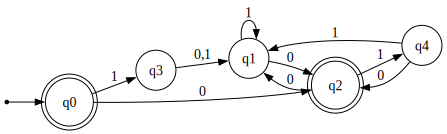

In [21]:
badr_dfa = DFA(
  states={'q0', 'q1', 'q2', 'q3', 'q4'},
  input_symbols={'0', '1'},
  transitions={
    'q0': {'0': 'q2', '1': 'q3'},
    'q1': {'0': 'q2', '1': 'q1'},
    'q2': {'0': 'q1', '1': 'q4'},
    'q3': {'0': 'q1', '1': 'q1'},
    'q4': {'0': 'q2', '1': 'q1'}
  },
  initial_state='q0',
  final_states={'q2', 'q0'},
)
badr_dfa

Just for the sake of completeness, below is the minified (in the standard way) automaton.

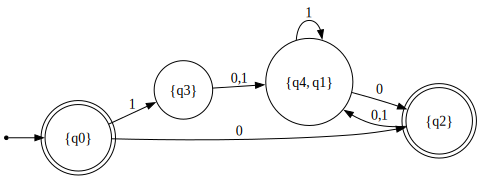

In [22]:
badr_dfa.minify(retain_names=True)

Finally, below is the hyper-minimized automaton obtained using respectively the Badr-Geffert-Shipman, Badr and Holzer-Maletti algorithms.

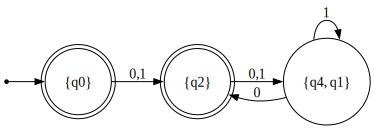

In [23]:
badr_geffert_shipman_hyper_minimize(badr_dfa)

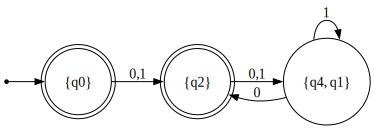

In [24]:
badr_hyper_minimize(badr_dfa)

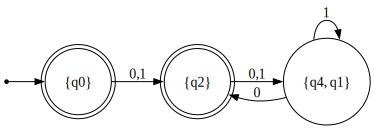

In [25]:
holzer_maletti_hyper_minimize(badr_dfa)

A little performance comparison is also provided.

In [26]:
print("Badr-Geffert-Shipman algorithm time:", timeit.timeit(lambda: badr_geffert_shipman_hyper_minimize(badr_dfa), number=10000))

Badr-Geffert-Shipman algorithm time: 1.3983173749875277


In [27]:
print("Badr algorithm time:", timeit.timeit(lambda: badr_hyper_minimize(badr_dfa), number=10000))

Badr algorithm time: 1.56662741699256


In [28]:
print("Holzer-Maletti algorithm time:", timeit.timeit(lambda: holzer_maletti_hyper_minimize(badr_dfa), number=10000))

Holzer-Maletti algorithm time: 1.2764648330048658


### Example 2

Here is another, more extended, example of DFA on which the hyper minimization will be performed from [An nlogn
algorithm for hyper-minimizing a (minimized) deterministic automaton](https://www.sciencedirect.com/science/article/pii/S030439751000321X) paper by Holzer and Maletti.

Note: the automaton is already minimized in the standard way.

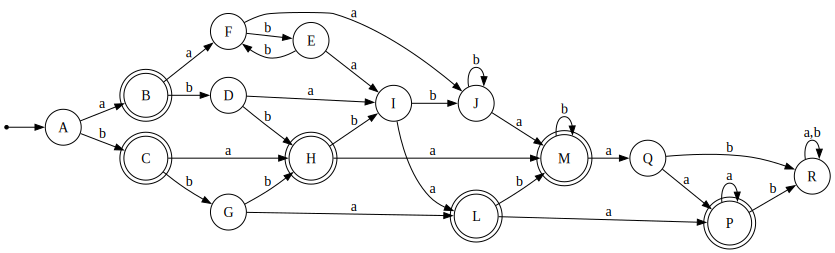

In [29]:
holzer_maletti_dfa = DFA(
  states={'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'P', 'Q', 'R'},
  input_symbols={'a', 'b'},
  initial_state='A',
  final_states={'B', 'C', 'H', 'M', 'L', 'P'},
  transitions={
    'A': {'a': 'B', 'b': 'C'},
    'B': {'a': 'F', 'b': 'D'},
    'C': {'a': 'H', 'b': 'G'},
    'D': {'a': 'I', 'b': 'H'},
    'E': {'a': 'I', 'b': 'F'},
    'F': {'a': 'J', 'b': 'E'},
    'G': {'a': 'L', 'b': 'H'},
    'H': {'a': 'M', 'b': 'I'},
    'I': {'a': 'L', 'b': 'J'},
    'J': {'a': 'M', 'b': 'J'},
    'L': {'a': 'P', 'b': 'M'},
    'M': {'a': 'Q', 'b': 'M'},
    'P': {'a': 'P', 'b': 'R'},
    'Q': {'a': 'P', 'b': 'R'},
    'R': {'a': 'R', 'b': 'R'}
  }
)
holzer_maletti_dfa

Now the hyper-minimization is performed using the defined algorithms.

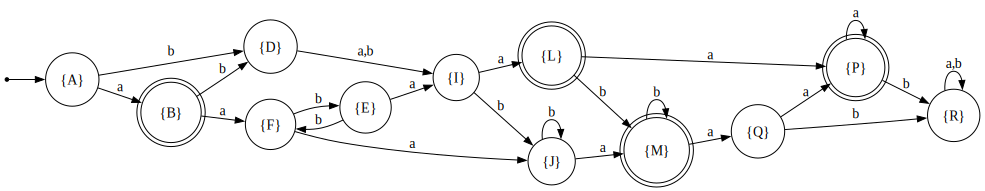

In [30]:
badr_geffert_shipman_hyper_minimize(holzer_maletti_dfa)

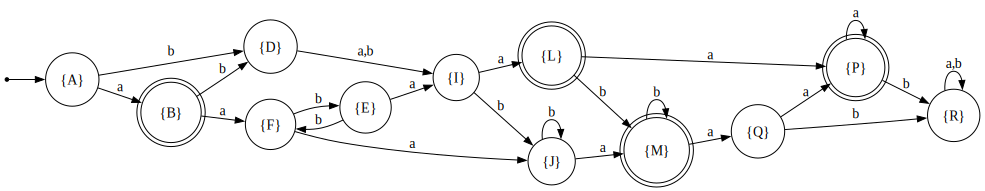

In [31]:
badr_hyper_minimize(holzer_maletti_dfa)

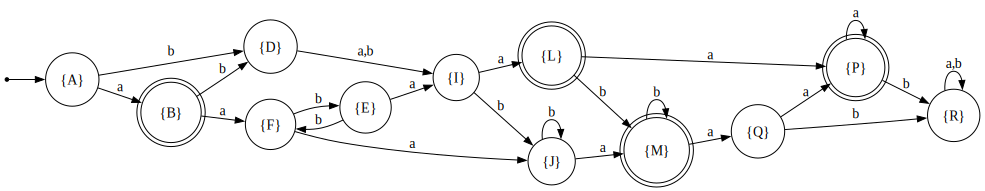

In [32]:
holzer_maletti_hyper_minimize(holzer_maletti_dfa)

Again, a preliminary performance comparison is provided.

In [33]:
print("Badr-Geffert-Shipman algorithm time:", timeit.timeit(lambda: badr_geffert_shipman_hyper_minimize(holzer_maletti_dfa), number=10000))

Badr-Geffert-Shipman algorithm time: 23.170872209011577


In [34]:
print("Badr algorithm time:", timeit.timeit(lambda: badr_hyper_minimize(holzer_maletti_dfa), number=10000))

Badr algorithm time: 8.889241208991734


In [35]:
print("Holzer-Maletti algorithm time:", timeit.timeit(lambda: holzer_maletti_hyper_minimize(holzer_maletti_dfa), number=10000))

Holzer-Maletti algorithm time: 4.652203292003833


### Proof of correctness

This section aims to demonstrate that each of the implemented algorithms generates a hyper-minimized automaton.

From the original paper:

_An automaton $M$ is hyper-minimized if and only if, in $M$:_
1. _there does not exist an unreachable state_
2. _there does not exist a pair of different but equivalent states_
3. _there does not exist a pair of different but almost-equivalent states, such that at least one of them is a preamble state_

Please note that the first two condition are satisfied if the automaton is already minimized in the standard way.

Here is defined an algorithm which verifies if a given automaton is hyper-minimized:

In [36]:
def is_hyper_minimal(dfa: DFA):
  """
  Checks if a DFA is hyper-minimal.
  """
  # check of the non-existence of unreachable states or couples of different but equivalent states
  minimal_dfa = dfa.minify(retain_names=True)
  if len(minimal_dfa.states) != len(dfa.states):
    return False
  
  # check of the non-existence of couples of different but almost-equivalent states using the strategy reported 
  # in the original paper with the use of the QuickUnion technique

  # first builds the partition of the states of the DFA into the almost-equivalence classes
  partition = QuickUnion()
  for q in minimal_dfa.states: # initial partitioning of the states Q = {q_1} ∪ {q_2} ∪ ... ∪ {q_n}
    partition.make_set(q)
  for _ in range(len(minimal_dfa.states)-1): # almost-equivalence relation computation
    for i_1 in minimal_dfa.states:
      for i_2 in minimal_dfa.states:
        if partition.find(i_1) != partition.find(i_2):
          almost_equivalent = all(partition.find(minimal_dfa.transitions[i_1][sigma]) == partition.find(minimal_dfa.transitions[i_2][sigma]) for sigma in minimal_dfa.input_symbols)
          if almost_equivalent:
            partition.union(i_1, i_2)

  preamble, _ = preamble_and_kernel(minimal_dfa) # badr algorithm

  return not any(len(preamble.intersection(s)) > 1 for s in partition.partition())

It basically minimizes the automaton in the standard way checking if the number of states is the same (validating conditions 1 and 2) and then checks if there are almost-equivalent states such that at least one of them is a preamble state (validating condition 3).

A quick validation of the results obtained by the three algorithms is provided.

In [37]:
(is_hyper_minimal(badr_dfa), is_hyper_minimal(holzer_maletti_dfa))

(False, False)

In [38]:
(
  is_hyper_minimal(badr_geffert_shipman_hyper_minimize(badr_dfa)),
  is_hyper_minimal(badr_hyper_minimize(badr_dfa)), 
  is_hyper_minimal(holzer_maletti_hyper_minimize(badr_dfa))
)

(True, True, True)

In [39]:
(
  is_hyper_minimal(badr_geffert_shipman_hyper_minimize(holzer_maletti_dfa)),
  is_hyper_minimal(badr_hyper_minimize(holzer_maletti_dfa)),
  is_hyper_minimal(holzer_maletti_hyper_minimize(holzer_maletti_dfa))
)

(True, True, True)

### Performance analysis

#### DFA generation

In [40]:
def generate_preamble(dfa: IncrementalDFA, n: int):
  preamble_states_matrix = np.array([[f'p{i}.{j}' for j in range(n)] for i in range(n)])
  for i in range(n):
    for j in range(n):
      dfa.transitions[preamble_states_matrix[i][j]] = dict()
      if j < n-1:
        dfa.transitions[preamble_states_matrix[i][j]]['a'] = preamble_states_matrix[i][j+1]
      if i < n-1:
        dfa.transitions[preamble_states_matrix[i][j]]['b'] = preamble_states_matrix[i+1][j]

  return preamble_states_matrix.flatten().tolist()

In [50]:
def generate_kernel(dfa: IncrementalDFA, n: int, multiple_scc: bool):
  states = [f'k{i}' for i in range(n)]
  sccs = QuickUnion()
  processed_states = set()

  # computes the strongly connected components of the kernel
  while len(processed_states) < n:
    scc_size = random.randint(1, n - len(processed_states)) if multiple_scc else n
    scc = random.sample(list(set(states) - processed_states), scc_size)
    
    sccs.make_set(scc[0])
    for i in range(1, scc_size):
      sccs.make_set(scc[i])
      sccs.union(scc[i-1], scc[i])
    
    processed_states = processed_states.union(set(scc))

  # computes the transitions between the states of each strongly connected component
  for scc in sccs.partition():
      scc_states = list(scc)
      for i in range(len(scc_states)):
        dfa.transitions[scc_states[i]] = dict()
        dfa.transitions[scc_states[i]]['a'] = scc_states[(i+1) % len(scc_states)]
        dfa.transitions[scc_states[i]]['b'] = random.choice(list(scc))

  # enforces the connection between different strongly connected components
  parts = sccs.partition()
  for i in range(len(parts)):
    for j in range(i+1, len(parts)):
      q_i = random.choice(list(parts[i]))
      q_j = random.choice(list(parts[j]))
      dfa.transitions[q_i]['b'] = q_j

  return states

In [51]:
def connect_preamble_kernel(dfa: IncrementalDFA, p_states: list, k_states: list):
  p_matrix_row_size = math.floor(math.sqrt(len(p_states)))
  p_matrix_bottom_row = p_states[-p_matrix_row_size:]
  p_matrix_right_col = [p_states[(p_matrix_row_size*i)-1] for i in range(1, p_matrix_row_size+1)]

  # all the preamble states on the states matrix bottom edge and right edge should be connected to the kernel
  # states, in particular, each state on the bottom edge should be connected using the transition of symbol 'b'
  # and each state on the right edge should be connected using the transition of symbol 'a' (except for the state
  # on the bottom right corner which should be connected using both transitions)
  k_conn_points = k_states.copy()
  if len(k_conn_points) < p_matrix_row_size*2:
    k_conn_points = (k_conn_points * math.ceil((p_matrix_row_size*2)/len(k_conn_points)))
  random.shuffle(k_conn_points)

  for q in p_matrix_bottom_row:
    dfa.transitions[q]['b'] = k_conn_points.pop()
  for q in p_matrix_right_col:
    dfa.transitions[q]['a'] = k_conn_points.pop()

In [52]:
def generate_dfa(num_of_states: int, p_states_ratio: float = 0.5, f_states_ratio: float = 0.5, multiple_scc=False) -> DFA:
  # initializes the DFA
  dfa = IncrementalDFA()
  dfa.input_symbols = {'a', 'b'}
  dfa.transitions = dict()

  # generates the preamble
  p_states = generate_preamble(dfa, math.floor(math.sqrt(num_of_states * p_states_ratio)))

  # generates the kernel
  k_states = generate_kernel(dfa, num_of_states - len(p_states), multiple_scc)

  # connects the preamble with the kernel
  connect_preamble_kernel(dfa, p_states, k_states)

  # dfa composition
  dfa.states = set(p_states + k_states)
  dfa.initial_state = p_states[0] if len(p_states) > 0 else random.choice(k_states)
  dfa.final_states = set(random.sample(k_states, math.floor(len(k_states) * f_states_ratio)))

  return dfa.build()

#### Testing the hyper-minimization effectivness among the generated automata

A bounch of graph to understand the hyper-minimization effectivness among the generated automata (used algorithm is the Holzer-Maletti since it is the one with the best performances).

##### Effectiveness among different final states ratios

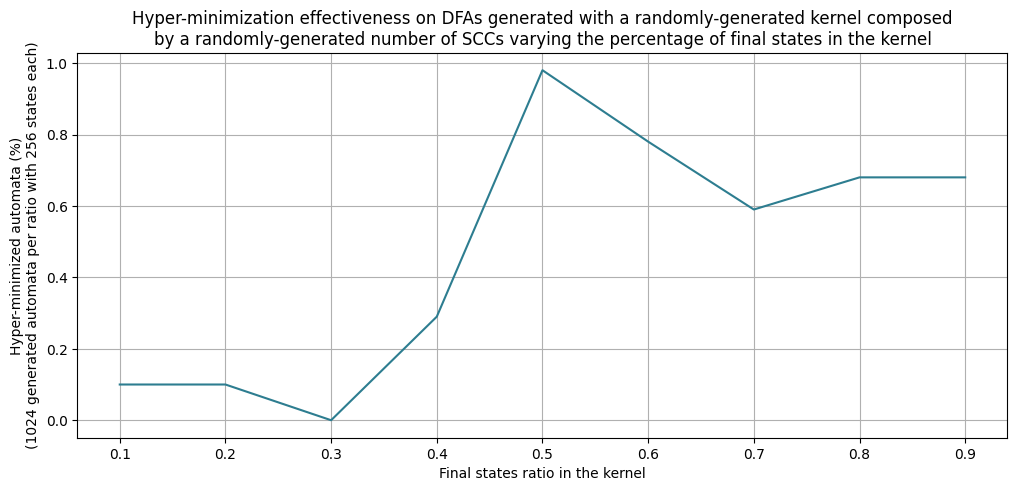

In [53]:
dfa_per_ratio = 1024
# fixed parameters
arg_p_states_ratio, arg_states_count = 0.5, 256
# varying parameters
f_states_ratios = np.linspace(0.1, 0.9, 9)

data = list()

# variation of the f_states_ratio
for f_states_ratio in f_states_ratios:
  hyper_minimized_count = 0

  # generation of automata to be hyper-minimized with the current f_states_ratio
  for i in range(dfa_per_ratio):
    dfa = generate_dfa(arg_states_count, arg_p_states_ratio, f_states_ratio, True)  # base dfa
    minimal = dfa.minify(retain_names=True)                                         # minimal dfa
    hyper_minimal = holzer_maletti_hyper_minimize(dfa)                              # hyper-minimal dfa

    # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
    if len(minimal.states) != len(hyper_minimal.states):
      hyper_minimized_count += 1

  # computes the percentage of hyper-minimized automata for the current f_states_ratio
  data.append(round((hyper_minimized_count / dfa_per_ratio) * 100, 2))

# plotting
plt.figure(figsize=(12, 5))

plt.title('Hyper-minimization effectiveness on DFAs generated with a randomly-generated kernel composed\nby a randomly-generated number of SCCs varying the percentage of final states in the kernel')
plt.xlabel('Final states ratio in the kernel')
plt.ylabel(f'Hyper-minimized automata (%)\n({dfa_per_ratio} generated automata per ratio with {arg_states_count} states each)')

plt.grid(True)  
plt.plot(f_states_ratios, data, color=color_palette[len(color_palette)//2])

plt.show()

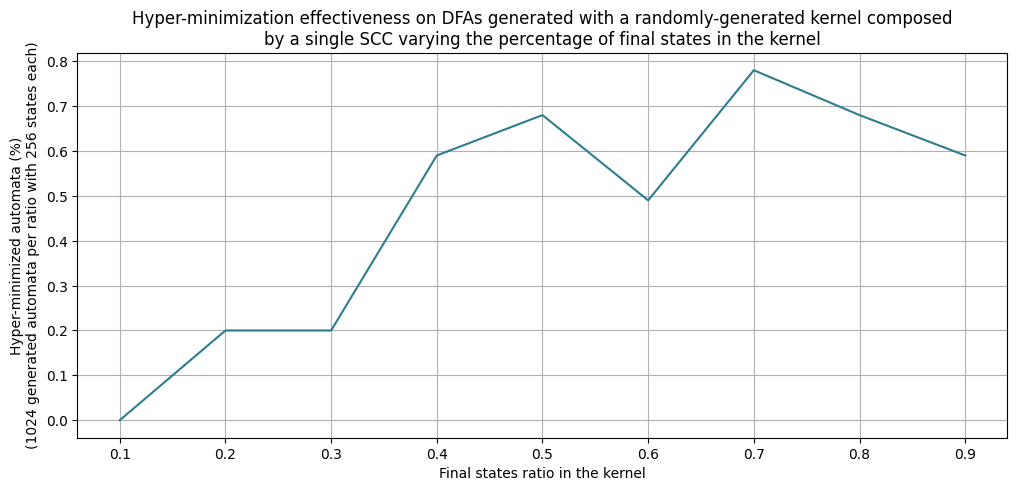

In [54]:
data = list()

# variation of the f_states_ratio
for f_states_ratio in f_states_ratios:
  hyper_minimized_count = 0

  # generation of automata to be hyper-minimized with the current f_states_ratio
  for i in range(dfa_per_ratio):
    dfa = generate_dfa(arg_states_count, arg_p_states_ratio, f_states_ratio, False) # base dfa
    minimal = dfa.minify(retain_names=True)                                         # minimal dfa
    hyper_minimal = holzer_maletti_hyper_minimize(dfa)                              # hyper-minimal dfa

    # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
    if len(minimal.states) != len(hyper_minimal.states):
      hyper_minimized_count += 1

  # computes the percentage of hyper-minimized automata for the current f_states_ratio
  data.append(round((hyper_minimized_count / dfa_per_ratio) * 100, 2))

# plotting
plt.figure(figsize=(12, 5))

plt.title('Hyper-minimization effectiveness on DFAs generated with a randomly-generated kernel composed\nby a single SCC varying the percentage of final states in the kernel')
plt.xlabel('Final states ratio in the kernel')
plt.ylabel(f'Hyper-minimized automata (%)\n({dfa_per_ratio} generated automata per ratio with {arg_states_count} states each)')

plt.grid(True)  
plt.plot(f_states_ratios, data, color=color_palette[len(color_palette)//2])

plt.show()

At first glance, mantaining the same number of states, hyper-minimization seems to be more effective when the ratio of final states is higher, indipendently from the kernel composition.

##### Effectiveness among different final states ratios and different number of states

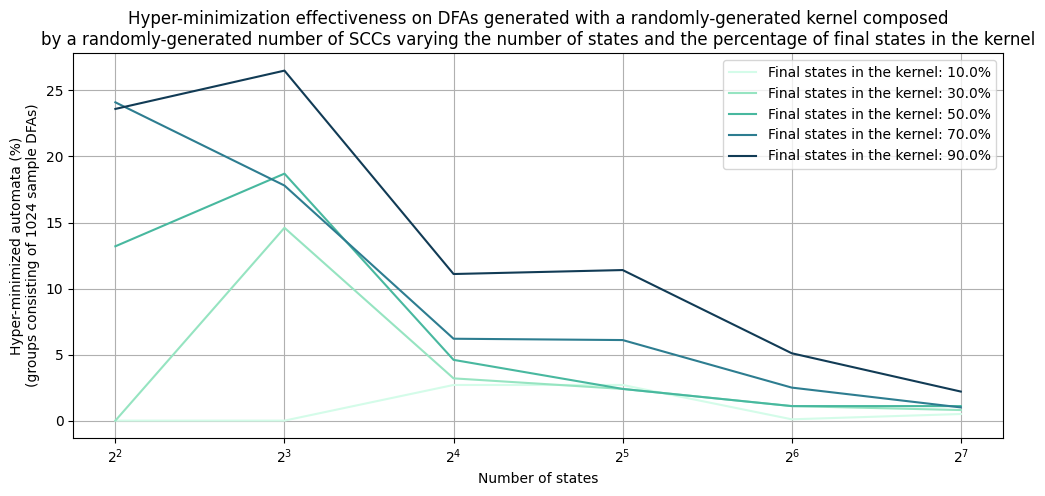

In [55]:
dfa_per_ratio = 1024
# fixed parameters
arg_p_states_ratio = 0.5
# varying parameters
f_states_ratios, states_count = np.linspace(0.1, 0.9, 5), [2**i for i in range(2, 8)]

data_matrix = dict()

# variation of the f_states_ratio
for f_states_ratio in f_states_ratios:
  data_matrix[f_states_ratio] = dict()

  # variation of the number of states
  for n in states_count:
    hyper_minimized = 0

    # generation of automata to be hyper-minimized with the current f_states_ratio and number of states n
    for i in range(dfa_per_ratio):
      rdfa = generate_dfa(n, arg_p_states_ratio, f_states_ratio, True) # base dfa
      mrdfa = rdfa.minify(retain_names=True)                           # minimal dfa
      hmrdfa = holzer_maletti_hyper_minimize(mrdfa)                    # hyper-minimal dfa

      # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
      if len(mrdfa.states) != len(hmrdfa.states):
        hyper_minimized += 1
    
    # computes the percentage of hyper-minimized automata for the current f_states_ratio and number of states n
    data_matrix[f_states_ratio][n] = round((hyper_minimized / 1000) * 100, 2)

# plotting
plt.figure(figsize=(12, 5))

plt.title('Hyper-minimization effectiveness on DFAs generated with a randomly-generated kernel composed\nby a randomly-generated number of SCCs varying the number of states and the percentage of final states in the kernel')
plt.xlabel('Number of states')
plt.ylabel(f'Hyper-minimized automata (%)\n(groups consisting of {dfa_per_ratio} sample DFAs)')

x_axis = [f'$2^{int(math.log2(n))}$' for n in states_count]
for i, f_states_ratio in enumerate(f_states_ratios):
  plt.plot(x_axis, list(data_matrix[f_states_ratio].values()), color=color_palette[i], label=f'Final states in the kernel: {round(f_states_ratio, 2) * 100}%')

plt.grid(True)
plt.legend()

plt.show()

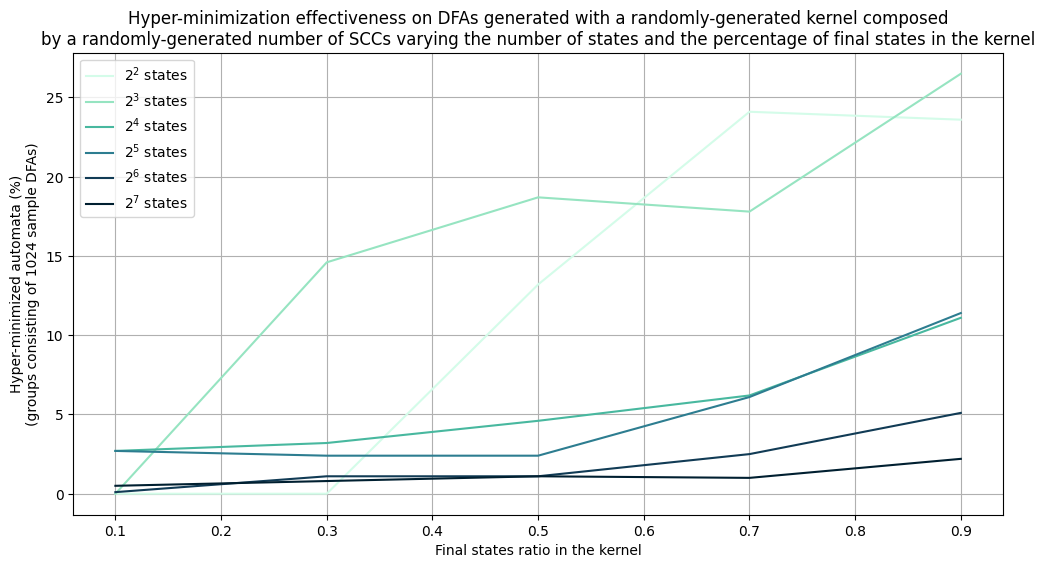

In [56]:
trasposed_data = [[data_matrix[y][x] for y in f_states_ratios] for x in states_count]

# plotting
plt.figure(figsize=(12, 6))

plt.title('Hyper-minimization effectiveness on DFAs generated with a randomly-generated kernel composed\nby a randomly-generated number of SCCs varying the number of states and the percentage of final states in the kernel')
plt.xlabel('Final states ratio in the kernel')
plt.ylabel(f'Hyper-minimized automata (%)\n(groups consisting of {dfa_per_ratio} sample DFAs)')

for i, d in enumerate(trasposed_data):
  plt.plot(f_states_ratios, d, color=color_palette[i], label=f'$2^{int(math.log2(states_count[i]))}$ states')

plt.grid(True)
plt.legend()

plt.show()

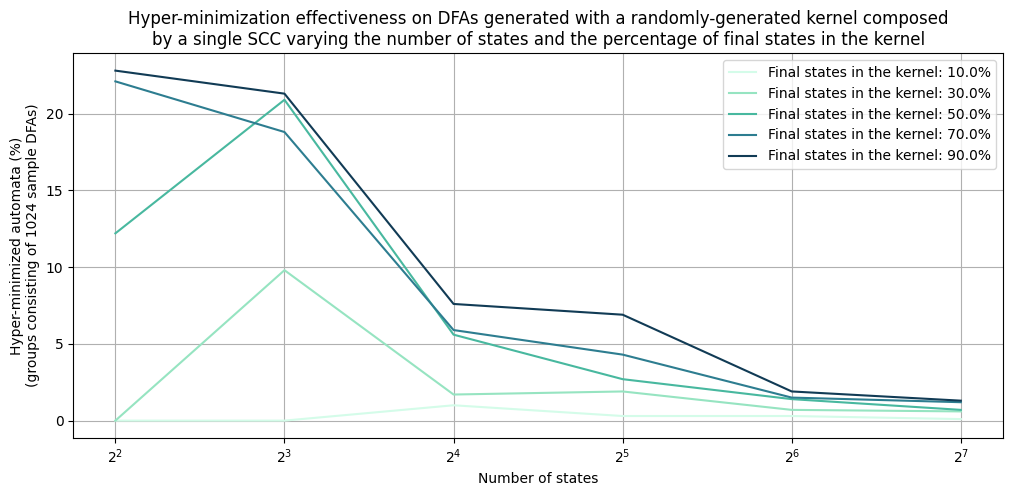

In [57]:
data_matrix = dict()

# variation of the f_states_ratio
for f_states_ratio in f_states_ratios:
  data_matrix[f_states_ratio] = dict()

  # variation of the number of states
  for n in states_count:
    hyper_minimized = 0

    # generation of automata to be hyper-minimized with the current f_states_ratio and number of states n
    for i in range(dfa_per_ratio):
      rdfa = generate_dfa(n, arg_p_states_ratio, f_states_ratio, False) # base dfa
      mrdfa = rdfa.minify(retain_names=True)                            # minimal dfa
      hmrdfa = holzer_maletti_hyper_minimize(mrdfa)                     # hyper-minimal dfa

      # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
      if len(mrdfa.states) != len(hmrdfa.states):
        hyper_minimized += 1
    
    # computes the percentage of hyper-minimized automata for the current f_states_ratio and number of states n
    data_matrix[f_states_ratio][n] = round((hyper_minimized / 1000) * 100, 2)

# plotting
plt.figure(figsize=(12, 5))

plt.title('Hyper-minimization effectiveness on DFAs generated with a randomly-generated kernel composed\nby a single SCC varying the number of states and the percentage of final states in the kernel')
plt.xlabel('Number of states')
plt.ylabel(f'Hyper-minimized automata (%)\n(groups consisting of {dfa_per_ratio} sample DFAs)')

x_axis = [f'$2^{int(math.log2(n))}$' for n in states_count]
for i, f_states_ratio in enumerate(f_states_ratios):
  plt.plot(x_axis, list(data_matrix[f_states_ratio].values()), color=color_palette[i], label=f'Final states in the kernel: {round(f_states_ratio, 2) * 100}%')

plt.grid(True)
plt.legend()

plt.show()

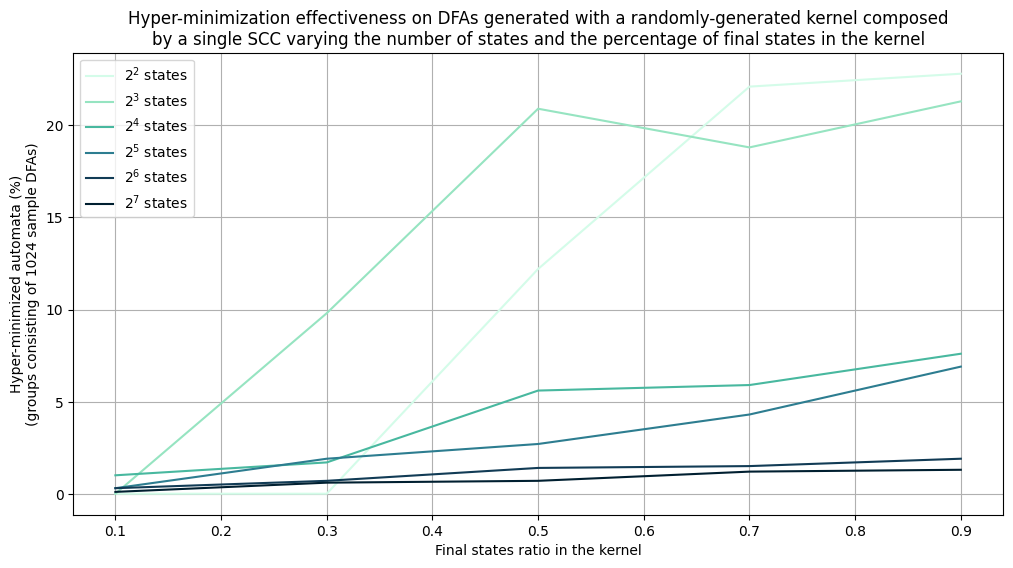

In [58]:
trasposed_data = [[data_matrix[y][x] for y in f_states_ratios] for x in states_count]

# plotting
plt.figure(figsize=(12, 6))

plt.title('Hyper-minimization effectiveness on DFAs generated with a randomly-generated kernel composed\nby a single SCC varying the number of states and the percentage of final states in the kernel')
plt.xlabel('Final states ratio in the kernel')
plt.ylabel(f'Hyper-minimized automata (%)\n(groups consisting of {dfa_per_ratio} sample DFAs)')

for i, d in enumerate(trasposed_data):
  plt.plot(f_states_ratios, d, color=color_palette[i], label=f'$2^{int(math.log2(states_count[i]))}$ states')

plt.grid(True)
plt.legend()

plt.show()

Results now show that, indipendently from the kernel composition, the hyper-minimization is more effective in automata with a lower number of states and an higher ratio of final states in the kernel.

##### Effectiveness among different final states ratios and different preamble/kernel states ratios

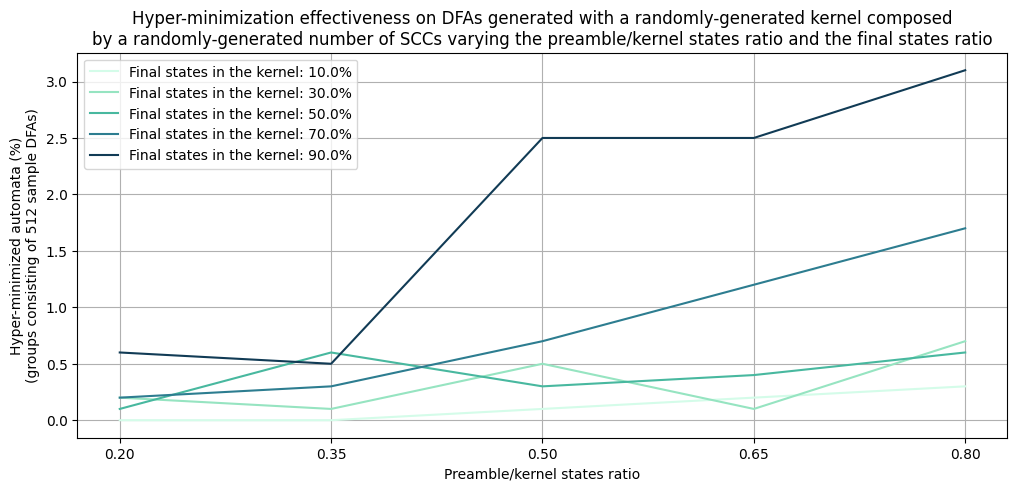

In [59]:
dfa_per_ratio = 512
# fixed parameters
arg_states_count = 128
# varying parameters
f_states_ratios, p_states_ratios = np.linspace(0.1, 0.9, 5), np.linspace(0.2, 0.8, 5)

data_matrix = dict()

# variation of the f_states_ratio
for f_states_ratio in f_states_ratios:
  data_matrix[f_states_ratio] = dict()

  # variation of the p_states_ratio
  for p_states_ratio in p_states_ratios:
    hyper_minimized = 0

    # generation of automata to be hyper-minimized with the current f_states_ratio and the current p_states_ratio
    for i in range(dfa_per_ratio):
      rdfa = generate_dfa(arg_states_count, p_states_ratio, f_states_ratio, True) # base dfa
      mrdfa = rdfa.minify(retain_names=True)                                      # minimal dfa
      hmrdfa = holzer_maletti_hyper_minimize(mrdfa)                               # hyper-minimal dfa

      # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
      if len(mrdfa.states) != len(hmrdfa.states):
        hyper_minimized += 1
    
    # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
    data_matrix[f_states_ratio][p_states_ratio] = round((hyper_minimized / 1000) * 100, 2)

# plotting
plt.figure(figsize=(12, 5))

plt.title('Hyper-minimization effectiveness on DFAs generated with a randomly-generated kernel composed\nby a randomly-generated number of SCCs varying the preamble/kernel states ratio and the final states ratio')
plt.xlabel('Preamble/kernel states ratio')
plt.ylabel(f'Hyper-minimized automata (%)\n(groups consisting of {dfa_per_ratio} sample DFAs)')

plt.xticks(p_states_ratios)
plt.grid(True)

x_axis = [round(states_ratio, 2) for states_ratio in p_states_ratios]
for i, f_states_ratio in enumerate(f_states_ratios):
  y_axis = list(data_matrix[f_states_ratio].values())
  plt.plot(x_axis, y_axis, color=color_palette[i], label=f'Final states in the kernel: {round(f_states_ratio, 2) * 100}%')

plt.legend()
plt.show()

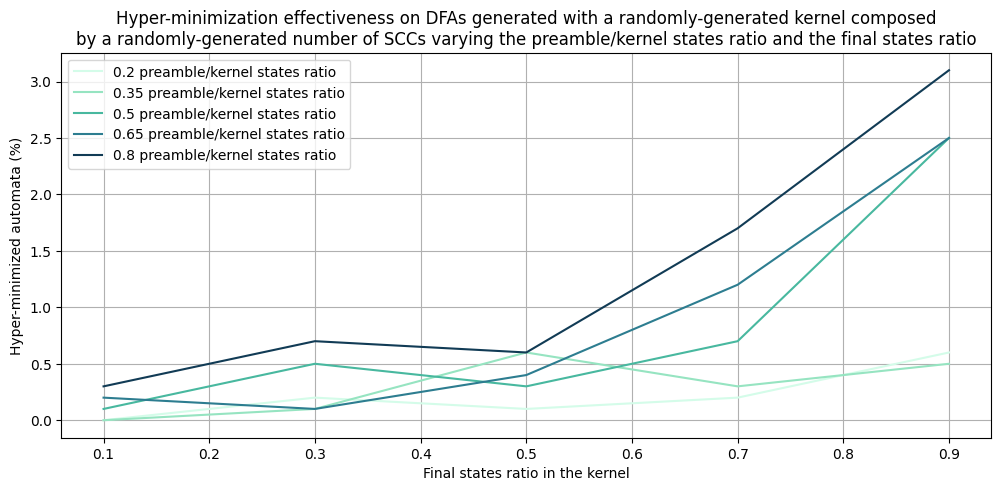

In [60]:
trasposed_data = [[data_matrix[y][x] for y in f_states_ratios] for x in p_states_ratios]

# plotting
plt.figure(figsize=(12, 5))

plt.title('Hyper-minimization effectiveness on DFAs generated with a randomly-generated kernel composed\nby a randomly-generated number of SCCs varying the preamble/kernel states ratio and the final states ratio')
plt.xlabel('Final states ratio in the kernel')
plt.ylabel(f'Hyper-minimized automata (%)')

for i, t_data in enumerate(trasposed_data):
  plt.plot(f_states_ratios, t_data, color=color_palette[i % len(color_palette)], label=f'{round(p_states_ratios[i], 2)} preamble/kernel states ratio')

plt.grid(True)
plt.legend()

plt.show()

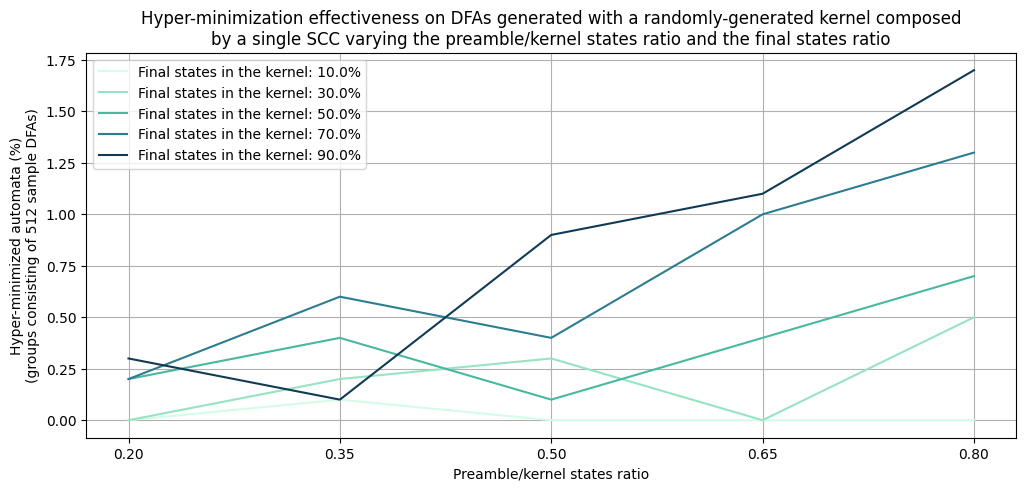

In [61]:
dfa_per_ratio = 512
# fixed parameters
arg_states_count = 128
# varying parameters
f_states_ratios, p_states_ratios = np.linspace(0.1, 0.9, 5), np.linspace(0.2, 0.8, 5)

data_matrix = dict()

# variation of the f_states_ratio
for f_states_ratio in f_states_ratios:
  data_matrix[f_states_ratio] = dict()

  # variation of the p_states_ratio
  for p_states_ratio in p_states_ratios:
    hyper_minimized = 0

    # generation of automata to be hyper-minimized with the current f_states_ratio and the current p_states_ratio
    for i in range(dfa_per_ratio):
      rdfa = generate_dfa(arg_states_count, p_states_ratio, f_states_ratio, False) # base dfa
      mrdfa = rdfa.minify(retain_names=True)                                       # minimal dfa
      hmrdfa = holzer_maletti_hyper_minimize(mrdfa)                                # hyper-minimal dfa

      # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
      if len(mrdfa.states) != len(hmrdfa.states):
        hyper_minimized += 1
    
    # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
    data_matrix[f_states_ratio][p_states_ratio] = round((hyper_minimized / 1000) * 100, 2)

# plotting
plt.figure(figsize=(12, 5))

plt.title('Hyper-minimization effectiveness on DFAs generated with a randomly-generated kernel composed\nby a single SCC varying the preamble/kernel states ratio and the final states ratio')
plt.xlabel('Preamble/kernel states ratio')
plt.ylabel(f'Hyper-minimized automata (%)\n(groups consisting of {dfa_per_ratio} sample DFAs)')

plt.xticks(p_states_ratios)
plt.grid(True)

x_axis = [round(states_ratio, 2) for states_ratio in p_states_ratios]
for i, f_states_ratio in enumerate(f_states_ratios):
  y_axis = list(data_matrix[f_states_ratio].values())
  plt.plot(x_axis, y_axis, color=color_palette[i], label=f'Final states in the kernel: {round(f_states_ratio, 2) * 100}%')

plt.legend()
plt.show()

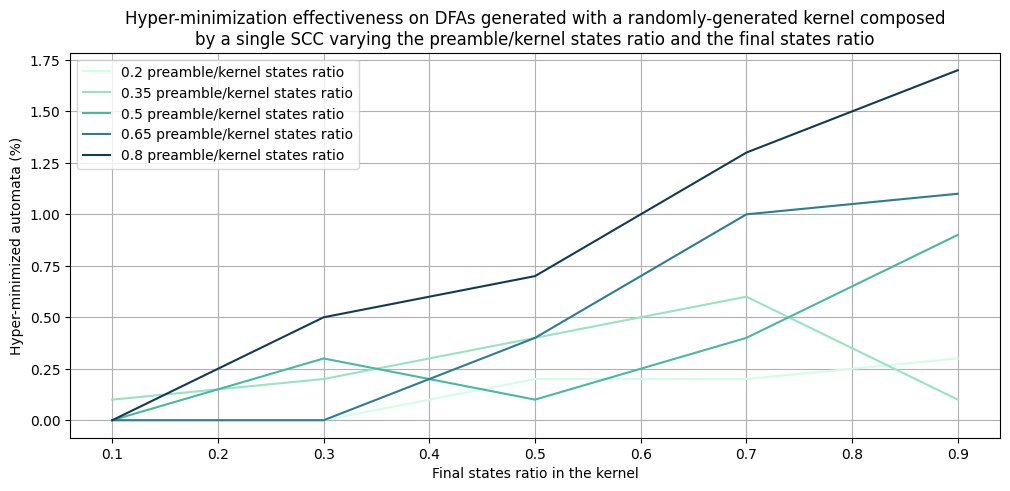

In [62]:
trasposed_data = [[data_matrix[y][x] for y in f_states_ratios] for x in p_states_ratios]

# plotting
plt.figure(figsize=(12, 5))

plt.title('Hyper-minimization effectiveness on DFAs generated with a randomly-generated kernel composed\nby a single SCC varying the preamble/kernel states ratio and the final states ratio')
plt.xlabel('Final states ratio in the kernel')
plt.ylabel(f'Hyper-minimized automata (%)')

for i, t_data in enumerate(trasposed_data):
  plt.plot(f_states_ratios, t_data, color=color_palette[i % len(color_palette)], label=f'{round(p_states_ratios[i], 2)} preamble/kernel states ratio')

plt.grid(True)
plt.legend()

plt.show()

Results indicates that the hyper-minimization is more effective in automata with a randomly-generated kernel composed by multiple SCCs where there is a higher ratio of preamble states and a higher ratio of final states in the kernel, in other words, the hyper-minimization is more effective in automata with a kernel of reduced size and with the majority of the states in the kernel.

##### Effectiveness among different number of states, different preamble/kernel states ratios and fixed high final states ratio

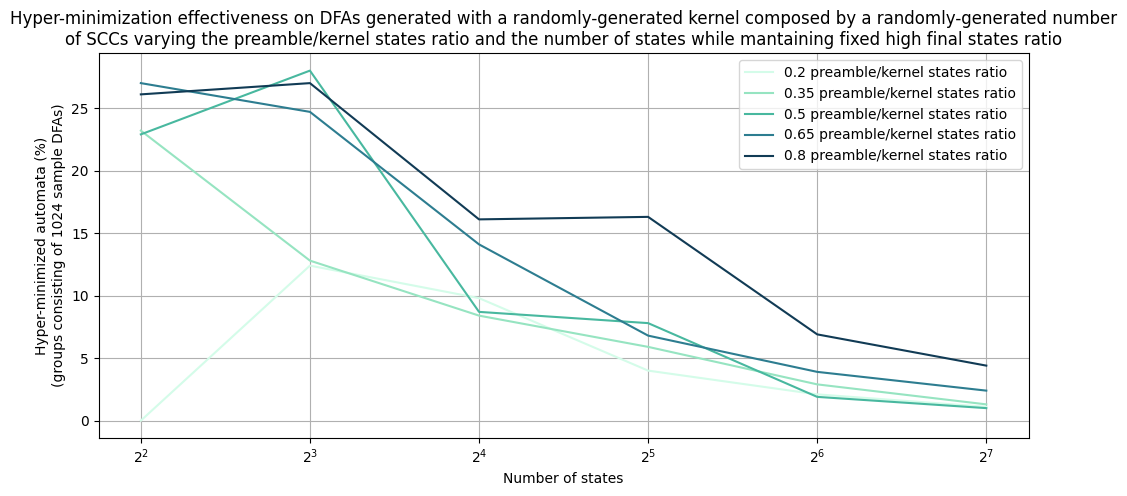

In [63]:
dfa_per_ratio = 1024
# fixed parameters
arg_f_states_ratios = 0.8
# varying parameters
states_count, p_states_ratios = [2**i for i in range(2, 8)], np.linspace(0.2, 0.8, 5)

data_matrix = dict()

# variation of the p_states_ratio
for p_states_ratio in p_states_ratios:
  data_matrix[p_states_ratio] = dict()

  # variation of the number of states
  for n in states_count:
    hyper_minimized = 0

    # generation of automata to be hyper-minimized with the current number of states and the current p_states_ratio
    for i in range(dfa_per_ratio):
      rdfa = generate_dfa(n, p_states_ratio, arg_f_states_ratios, True)  # base dfa
      mrdfa = rdfa.minify(retain_names=True)                             # minimal dfa
      hmrdfa = holzer_maletti_hyper_minimize(mrdfa)                      # hyper-minimal dfa

      # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
      if len(mrdfa.states) != len(hmrdfa.states):
        hyper_minimized += 1
    
    # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
    data_matrix[p_states_ratio][n] = round((hyper_minimized / 1000) * 100, 2)

# plotting
plt.figure(figsize=(12, 5))

plt.title('Hyper-minimization effectiveness on DFAs generated with a randomly-generated kernel composed by a randomly-generated number\nof SCCs varying the preamble/kernel states ratio and the number of states while mantaining fixed high final states ratio')
plt.xlabel('Number of states')
plt.ylabel(f'Hyper-minimized automata (%)\n(groups consisting of {dfa_per_ratio} sample DFAs)')

x_axis = [f'$2^{int(math.log2(n))}$' for n in states_count]
for i, states_ratio in enumerate(p_states_ratios):
  plt.plot(x_axis, data_matrix[states_ratio].values(), color=color_palette[i], label=f'{round(states_ratio, 2)} preamble/kernel states ratio')

plt.grid(True)
plt.legend()

plt.show()

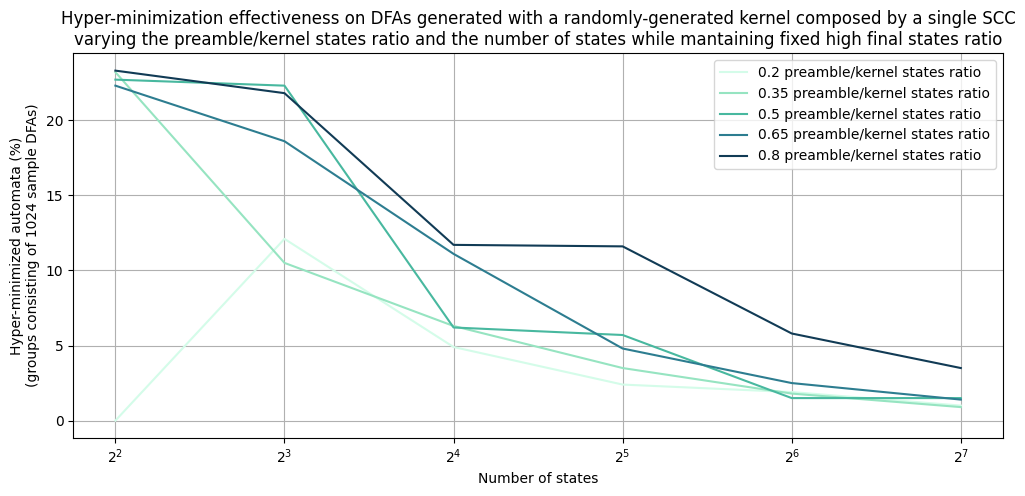

In [64]:
data_matrix = dict()

# variation of the p_states_ratio
for p_states_ratio in p_states_ratios:
  data_matrix[p_states_ratio] = dict()

  # variation of the number of states
  for n in states_count:
    hyper_minimized = 0

    # generation of automata to be hyper-minimized with the current number of states and the current p_states_ratio
    for i in range(dfa_per_ratio):
      rdfa = generate_dfa(n, p_states_ratio, arg_f_states_ratios, False)  # base dfa
      mrdfa = rdfa.minify(retain_names=True)                              # minimal dfa
      hmrdfa = holzer_maletti_hyper_minimize(mrdfa)                       # hyper-minimal dfa

      # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
      if len(mrdfa.states) != len(hmrdfa.states):
        hyper_minimized += 1
    
    # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
    data_matrix[p_states_ratio][n] = round((hyper_minimized / 1000) * 100, 2)

# plotting
plt.figure(figsize=(12, 5))

plt.title('Hyper-minimization effectiveness on DFAs generated with a randomly-generated kernel composed by a single SCC\nvarying the preamble/kernel states ratio and the number of states while mantaining fixed high final states ratio')
plt.xlabel('Number of states')
plt.ylabel(f'Hyper-minimized automata (%)\n(groups consisting of {dfa_per_ratio} sample DFAs)')

x_axis = [f'$2^{int(math.log2(n))}$' for n in states_count]
for i, states_ratio in enumerate(p_states_ratios):
  plt.plot(x_axis, data_matrix[states_ratio].values(), color=color_palette[i], label=f'{round(states_ratio, 2)} preamble/kernel states ratio')

plt.grid(True)
plt.legend()

plt.show()

Results shows that indipendently from the kernel composition, the hyper-minimization is more effective in automata with a lower number of states and an higher ratio of preamble/kernel states, in other words, automata with a kernel of reduced size and high preamble/kernel ratio (considering an high final states ratio in the kernel) are more likely to be hyper-minimized.

### Experimental results

Following the previous dfa-generation analysis, below are defined the parameters used to generate the automata for the performance analysis.

In [72]:
num_of_states = [2**exp for exp in range(1, 7)] # automata have a number of state not so high
p_states_ratio = 0.8 # high p_states_ratio to mantain kernels of reduced size
f_states_ratio = 0.8 # high f_states_ratio to mantain high effectiveness of the hyper-minimization
multiple_scc = True # always builds up a kernel composed by multiple SCCs to mantain a high hyper-minimization effectiveness

A test suite generator function is defined, this function generates a list (group) of test cases (DFAs with fixed number of states depending on the group).

In [73]:
def generate_test_suite(tests_per_group = 100) -> list[list[DFA]]:
  """
  Generate a test suite divided into groups of test automata with equal number of states for the hyper-minimization algorithms.
  """
  return [[generate_dfa(n, p_states_ratio, f_states_ratio, multiple_scc) for _ in range(tests_per_group)] for n in num_of_states]

A test-runner function is defined, this function runs the given hyper-minimization algorithm on the given test cases and saves the results in a `.csv` file.

The progress of the execution is printed as output along with the name of the file where the report is saved.

In [74]:
def run_tests(suite: list[list[DFA]], algorithm: callable):
  """
  Run a test suite of DFAs using a given algorithm and stores the results in a CSV file.
  """
  with open(algorithm.__name__ + '.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Test Group', 'Test Number', 'Initial Number of States', 'Minimal Number of States', 'Hyper-Minimal Number of States', 'Hyper-Minimal Check', 'Elapsed Time (s)'])

    # iterate over each group of tests
    for i in range(len(suite)):
      # iterate over each test in the current group
      for j in range(len(suite[i])):
        # logs the running test
        print(f"Running test {i + 1}.{j + 1}.", end="\r")

        dfa_states = len(suite[i][j].states)                    # initial number of states
        minimal_dfa_states = len(suite[i][j].minify().states)   # number of states in the minimal DFA
        hyper_minimal_dfa: DFA = None                           # hyper-minimal DFA
        
        def _exec():
          nonlocal hyper_minimal_dfa
          hyper_minimal_dfa = algorithm(suite[i][j])

        time = timeit.timeit(_exec, number=1)

        csvwriter.writerow([i, j, dfa_states, minimal_dfa_states, len(hyper_minimal_dfa.states), is_hyper_minimal(hyper_minimal_dfa), time])

      # logs the end of the group of tests
      print("Test suite", i + 1, "completed.")
    
    # logs the end
    print("Test suite completed, results at \"" + algorithm.__name__ + ".csv\"")

Following a test suite is generated and the tests are executed using the Badr-Geffert-Shipman, Badr and Holzer-Maletti algorithms.

In [75]:
test_suite = generate_test_suite(128)

In [76]:
badr_geffert_shipman_results = run_tests(test_suite, badr_geffert_shipman_hyper_minimize)

Test suite 1 completed.
Test suite 2 completed.
Test suite 3 completed.
Test suite 4 completed.
Test suite 5 completed.
Test suite 6 completed.
Test suite completed, results at "badr_geffert_shipman_hyper_minimize.csv"


In [77]:
badr_results = run_tests(test_suite, badr_hyper_minimize)

Test suite 1 completed.
Test suite 2 completed.
Test suite 3 completed.
Test suite 4 completed.
Test suite 5 completed.
Test suite 6 completed.
Test suite completed, results at "badr_hyper_minimize.csv"


In [78]:
holzer_maletti_results = run_tests(test_suite, holzer_maletti_hyper_minimize)

Test suite 1 completed.
Test suite 2 completed.
Test suite 3 completed.
Test suite 4 completed.
Test suite 5 completed.
Test suite 6 completed.
Test suite completed, results at "holzer_maletti_hyper_minimize.csv"


Results are now loaded into the notebook.

In [79]:
badr_geffert_shipman_results = pd.read_csv('badr_geffert_shipman_hyper_minimize.csv')
badr_results = pd.read_csv('badr_hyper_minimize.csv')
holzer_maletti_results = pd.read_csv('holzer_maletti_hyper_minimize.csv')

The first analysis is about the time taken by the algorithms to hyper-minimize the automata.

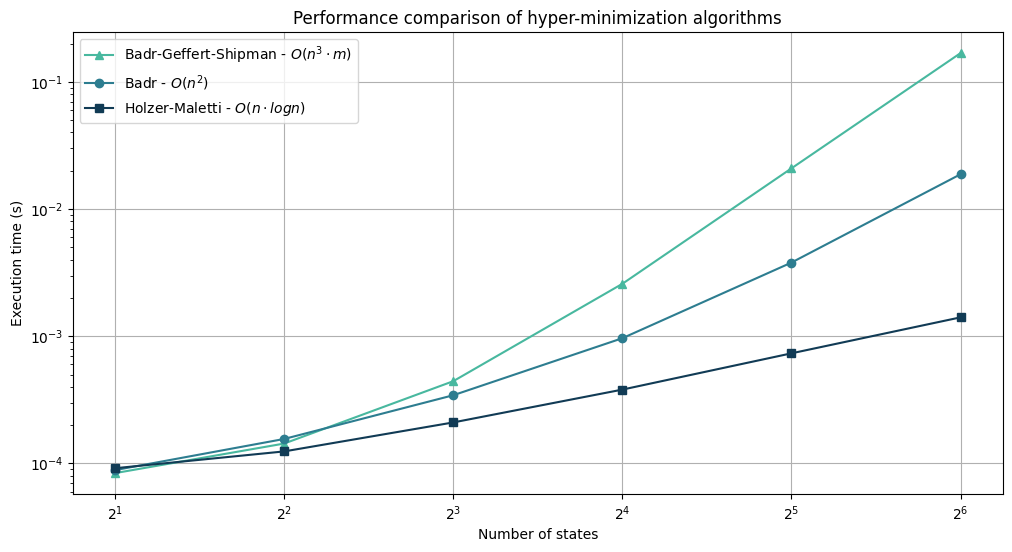

In [80]:
# mean time for each group of tests and each algorithm
badr_geffert_shipman_mean = badr_geffert_shipman_results[['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').mean()['Elapsed Time (s)'].values
badr_mean = badr_results[['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').mean()['Elapsed Time (s)'].values
holzer_maletti_mean = holzer_maletti_results[['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').mean()['Elapsed Time (s)'].values

# plot settings and customization
plt.figure(figsize=(12, 6))
plt.title('Performance comparison of hyper-minimization algorithms')
plt.xlabel('Number of states')
plt.ylabel('Execution time (s)')
plt.yscale('log') # setting le y label to log scale since the times are very different
plt.grid(True)

# plotting
x_labels = [f'$2^{int(math.log2(n))}$' for n in num_of_states]
plt.plot(x_labels, badr_geffert_shipman_mean, label='Badr-Geffert-Shipman - $O(n^3 \\cdot m)$', color=color_palette[(len(color_palette)//2)-1], marker='^')
plt.plot(x_labels, badr_mean, label='Badr - $O(n^2)$', color=color_palette[(len(color_palette)//2)], marker='o')
plt.plot(x_labels, holzer_maletti_mean, label='Holzer-Maletti - $O(n \\cdot logn)$', color=color_palette[(len(color_palette)//2)+1], marker='s')
plt.legend()

plt.show()

A more detailed plot, always about the time taken by the algorithms to hyper-minimize the automata, is provided.

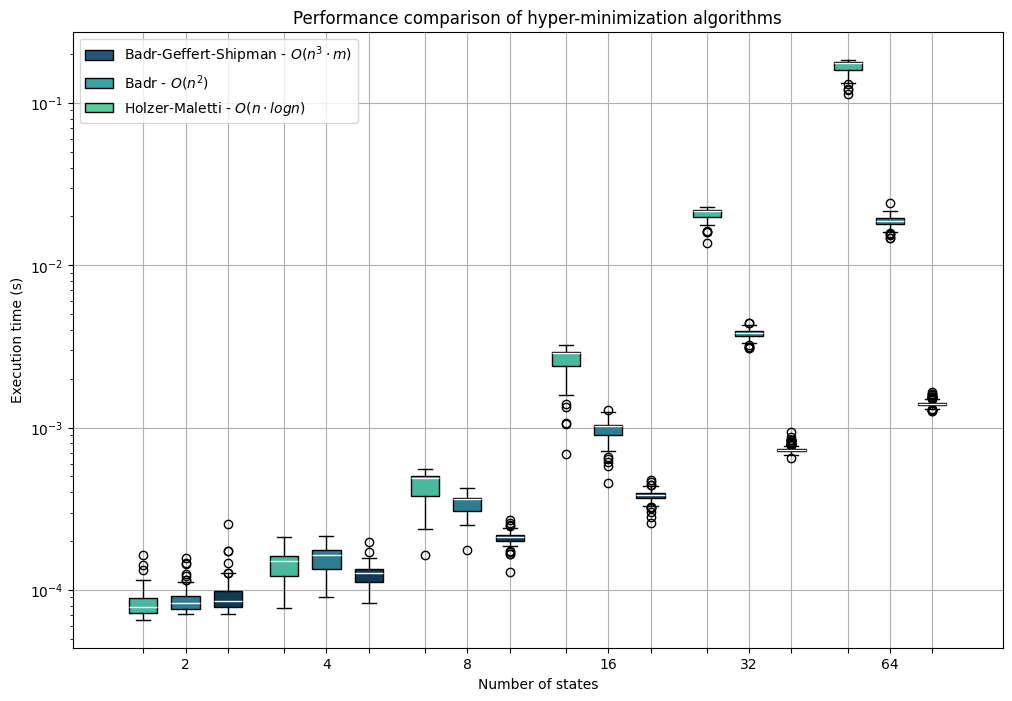

In [81]:
# below is defined a function to easily compute the data for the boxplot for each algorithm
def compute_box_data(dataframe: pd.DataFrame) -> list[list[float]]:
  """
  Computes the data for the boxplot from the dataframe.
  """
  return [dataframe[dataframe['Test Group'] == i]['Elapsed Time (s)'].values for i in dataframe['Test Group'].unique()]

# plot customization
plt.figure(figsize=(12, 8))
# custom legend
legend_elements = [Patch(facecolor=color, edgecolor='black', label=label) for color, label in zip(['#22577a', '#38a3a5', '#57cc99'], ['Badr-Geffert-Shipman - $O(n^3 \\cdot m)$', 'Badr - $O(n^2)$', 'Holzer-Maletti - $O(n \\cdot logn)$'])]
plt.legend(handles=legend_elements)
plt.grid(True)

# plotting
positions = np.arange(1, len(test_suite)+1) # positions of the box plots
plt.boxplot(compute_box_data(badr_geffert_shipman_results), positions=positions - 0.3, widths=0.2, patch_artist=True, boxprops=dict(facecolor=color_palette[(len(color_palette)//2)-1]), medianprops=dict(color='white') , labels=["" for _ in range(len(test_suite))])
plt.boxplot(compute_box_data(badr_results), positions=positions, widths=0.2, patch_artist=True, boxprops=dict(facecolor=color_palette[len(color_palette)//2]), medianprops=dict(color='white'), labels=num_of_states)
plt.boxplot(compute_box_data(holzer_maletti_results), positions=positions + 0.3, widths=0.2, patch_artist=True, boxprops=dict(facecolor=color_palette[(len(color_palette)//2)+1]), medianprops=dict(color='white'), labels=["" for _ in range(len(test_suite))])

# title, labels and scale
plt.title('Performance comparison of hyper-minimization algorithms')
plt.xlabel('Number of states')
plt.ylabel('Execution time (s)')
plt.yscale('log') # same scale as previous plot for the same reason

plt.show()

#### Performance profiling

A more in-depth analysis on how the 3 algorithms spend their time is provided below using the `pyinstrument` library and generating a `speedscope` profile that can be visualized [here](https://www.speedscope.app/).

The tools are run on the biggest automaton generated in the previous test suite that can be hyper-minimized by the 3 algorithms.

In [82]:
biggest_automaton = badr_geffert_shipman_results[badr_geffert_shipman_results['Minimal Number of States'] != badr_geffert_shipman_results['Hyper-Minimal Number of States']].iloc[-1]

In [83]:
%%pyinstrument

_ = badr_geffert_shipman_hyper_minimize(test_suite[biggest_automaton['Test Group']][biggest_automaton['Test Number']])

_     ._   __/__   _ _  _  _ _/_   Recorded: 22:44:47  Samples:  353
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.354     CPU time: 0.354
/   _/                      v4.6.2

Program: /Users/andrea/Desktop/uni/bachelor-thesis/code/py-playground/.venv/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/andrea/Library/Jupyter/runtime/kernel-v2-74721rIHADL4AOcnj.json

0.354 <module>  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/2893721630.py:1
`- 0.354 badr_geffert_shipman_hyper_minimize  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/1043924144.py:1
   |- 0.224 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/1043924144.py
   |- 0.051 <genexpr>  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/1043924144.py:38
   |- 0.037 breadth_first_search  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/1290113701.py:1
   |  |- 0.017 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/1290113701.py
   |  |- 0.008 list.append  <built-in>
   |  |- 0.007 list.pop  <built-in>
   |  `- 0.005 set.add  <built-in>
   |- 0.035 all  <built-in>
   `- 0.005 DFA.minify  automata/fa/dfa.py:535
         [2 frames hidden]  automata

In [84]:
%%pyinstrument

_ = badr_hyper_minimize(test_suite[biggest_automaton['Test Group']][biggest_automaton['Test Number']])

_     ._   __/__   _ _  _  _ _/_   Recorded: 22:44:49  Samples:  69
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.140     CPU time: 0.140
/   _/                      v4.6.2

Program: /Users/andrea/Desktop/uni/bachelor-thesis/code/py-playground/.venv/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/andrea/Library/Jupyter/runtime/kernel-v2-74721rIHADL4AOcnj.json

0.139 <module>  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/2496734331.py:1
`- 0.139 badr_hyper_minimize  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/1741877194.py:1
   |- 0.100 f_equivalence_classes  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/2107492206.py:1
   |  |- 0.083 xor_cross_product  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/3414771707.py:1
   |  |  |- 0.079 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/3414771707.py
   |  |  `- 0.003 IPythonKernel._clean_thread_parent_frames  ipykernel/ipkernel.py:770
   |  |- 0.015 right_finite_state  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/2306569026.py:1
   |  |  |- 0.010 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/2306569026.py
   |  |  |- 0.003 IPythonKernel._clean_thread_parent_frames  ipykernel/ipkernel.py:770
   |  |  `- 0.002 set.add  <built-in>
   |  `- 0.002 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/2107492206.py
   |- 0.029 preamble_and_kernel  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/1985188727.py:1
   |  `- 0.029 breadth_first_search  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/1290113701.py:1
   |     |- 0.014 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/1290113701.py
   |     |- 0.008 list.pop  <built-in>
   |     |- 0.004 set.add  <built-in>
   |     `- 0.003 list.append  <built-in>
   `- 0.007 DFA.minify  automata/fa/dfa.py:535
         [2 frames hidden]  automata

In [85]:
%%pyinstrument

_ = holzer_maletti_hyper_minimize(test_suite[biggest_automaton['Test Group']][biggest_automaton['Test Number']])

_     ._   __/__   _ _  _  _ _/_   Recorded: 22:44:50  Samples:  8
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.009     CPU time: 0.009
/   _/                      v4.6.2

Program: /Users/andrea/Desktop/uni/bachelor-thesis/code/py-playground/.venv/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/andrea/Library/Jupyter/runtime/kernel-v2-74721rIHADL4AOcnj.json

0.008 <module>  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/233222721.py:1
`- 0.008 holzer_maletti_hyper_minimize  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/2528965397.py:1
   |- 0.005 DFA.minify  automata/fa/dfa.py:535
   |     [14 frames hidden]  automata, <built-in>
   |        0.002 PartitionRefinement.refine  automata/base/utils.py:176
   |- 0.002 IncrementalDFA.build  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/866836702.py:28
   |  `- 0.002 DFA.__init__  automata/fa/dfa.py:105
   |        [10 frames hidden]  automata, <built-in>
   `- 0.001 almost_equivalent_states  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/762928658.py:1
      `- 0.001 merge  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_74930/3417692101.py:1

In [99]:
with speedscope.track('badr_geffert_shipman.json'):
  badr_geffert_shipman_hyper_minimize(test_suite[biggest_automaton['Test Group']][biggest_automaton['Test Number']])

In [98]:
with speedscope.track('badr.json'):
  badr_hyper_minimize(test_suite[biggest_automaton['Test Group']][biggest_automaton['Test Number']])

In [100]:
with speedscope.track('holzer_maletti.json'):
  holzer_maletti_hyper_minimize(test_suite[biggest_automaton['Test Group']][biggest_automaton['Test Number']])